# Pytorch NB 2

We'll use the same NN from last example but experiment to see if we can get wow performance. 
Things to experiment with: amount of data, number and size of hidden layers, training time.

Overall results: reducing network size and increasing data actually made performance look better, which makes sense--when the architecture is too big for the amount of data we have we can't get parameters to converge well. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim

In [2]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler


In [106]:
# generating some time series data
class gen_synth_ts:

    def __init__(self, t_train=200,t_test=20):
        self.t_train = t_train
        self.t_test = t_test
        self.t_length = self.t_train+self.t_test
        np.random.seed(31)
        self.t = np.arange(0,self.t_length)

    def build_random_datasets(self, n_datasets = 16000):
        self.datasets = []

        for i in range(n_datasets):
            self.ar_scale = np.random.uniform(1, 100)
            self.ar_comp = self.ar_scale*self.sim_ar(thetas = [-0.2,0.2])
            self.linear_comp = self.sim_lin(slope = np.random.uniform(-10,10), intercept=np.random.uniform(-10,10))
            self.noise = np.random.normal(0, np.random.uniform(1, 100), self.t_length)
            
            self.cyclic_comps = []
            num_cyclic_comps = np.random.randint(10,1000)
            for i in range(num_cyclic_comps):
                order = np.random.choice([1,2,3])
                freq_bounds = [0.1/(10**order), 1/(10**order)]
                cyclic_comp = self.sim_cyclic(amplitude = np.random.uniform(1,50), frequency=np.random.uniform(freq_bounds[0],freq_bounds[1]), phase=np.random.uniform(-100, 100))
                self.cyclic_comps.append(cyclic_comp)

            dataset = self.ar_comp + self.linear_comp + self.noise + sum(self.cyclic_comps)
            self.datasets.append(dataset)
        
    def plot_dataset(self, dataset_idx):
        plt.figure(figsize=(20,5))
        plt.plot(self.t, self.datasets[dataset_idx], alpha=0.3)
        plt.scatter(self.t, self.datasets[dataset_idx])
        plt.title('Dataset Number ' + str(dataset_idx))
        
    def sim_cyclic(self, amplitude, frequency, phase):
        cyc = amplitude*np.sin(2*np.pi*frequency*(self.t + phase))
        return cyc
        
    def sim_lin(self, slope, intercept):
        lin_val = slope*self.t + intercept
        return lin_val
        
    def sim_ar(self, intercept = 0, thetas = [-0.9,0.9], noise_var = 0.3):
        self.ar_order = len(thetas) # by default it's 2; aka AR(2) process
        X = np.zeros(self.t_length)
        X[:self.ar_order] = intercept
        for i in range(self.ar_order, self.t_length):
            X[i] = np.sum(thetas*np.flip(X[(i-self.ar_order):i])) + np.random.normal(0, noise_var)
        return X

    def sim_poly(self, coeffs = [0, -0.001,0.000002]):
        X = np.zeros(self.t_length)
        for i in range(len(coeffs)):
            X = X + coeffs[i]*self.t**(i+1)
        return X

    def plot_data(self):
        plt.figure(figsize=(20,5))
        plt.plot(self.t, self.data)
        plt.title('Sim Time Series')
        plt.figure(figsize=(20,5))
        plt.scatter(self.t, self.data)
        plt.title('Sim Time Series')
        


In [107]:
sts = gen_synth_ts()
sts.build_random_datasets()

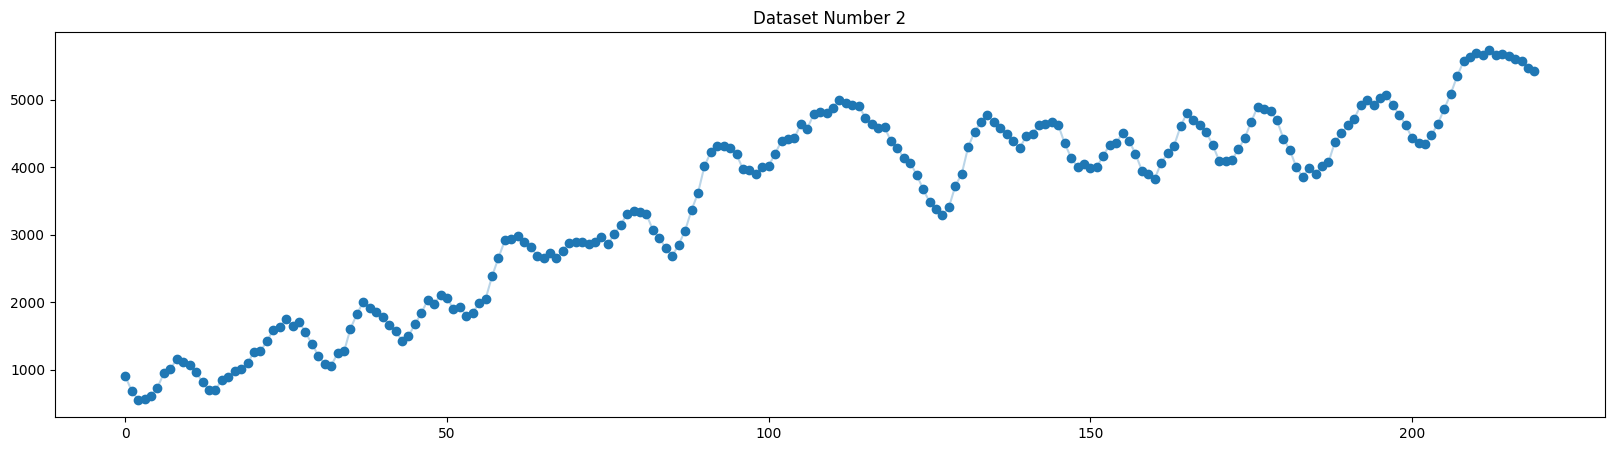

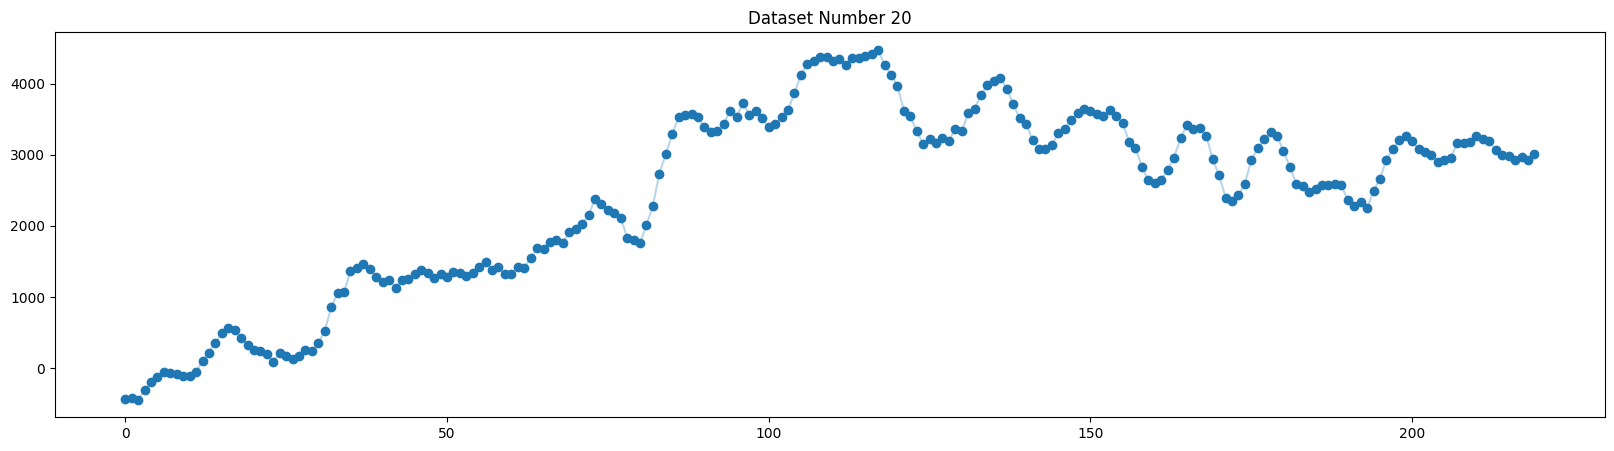

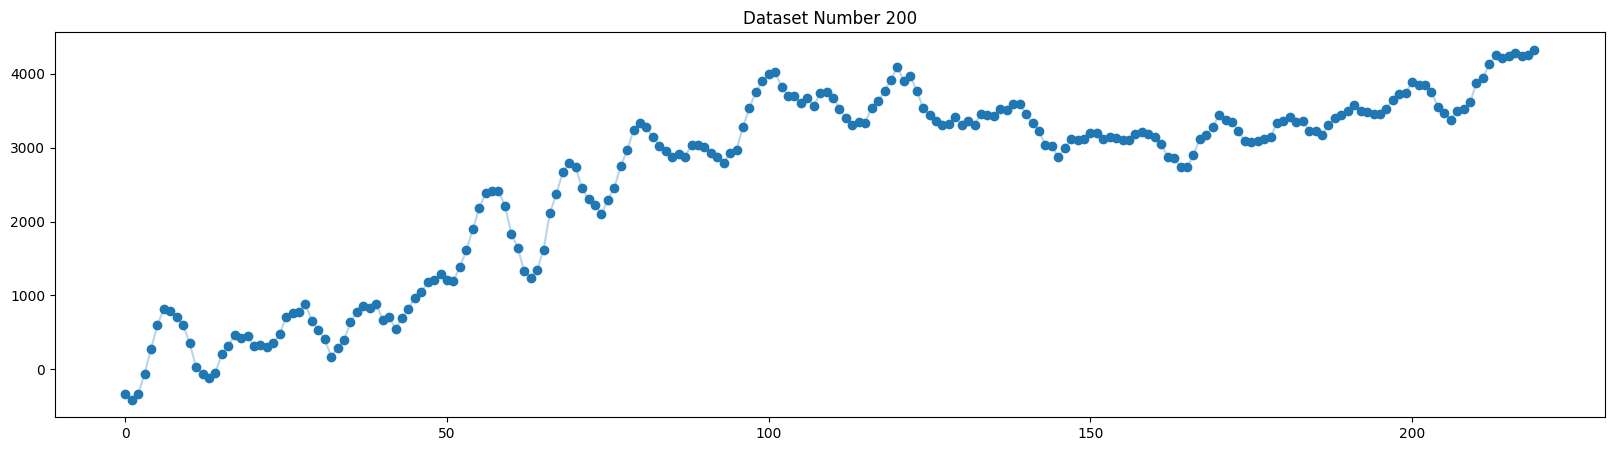

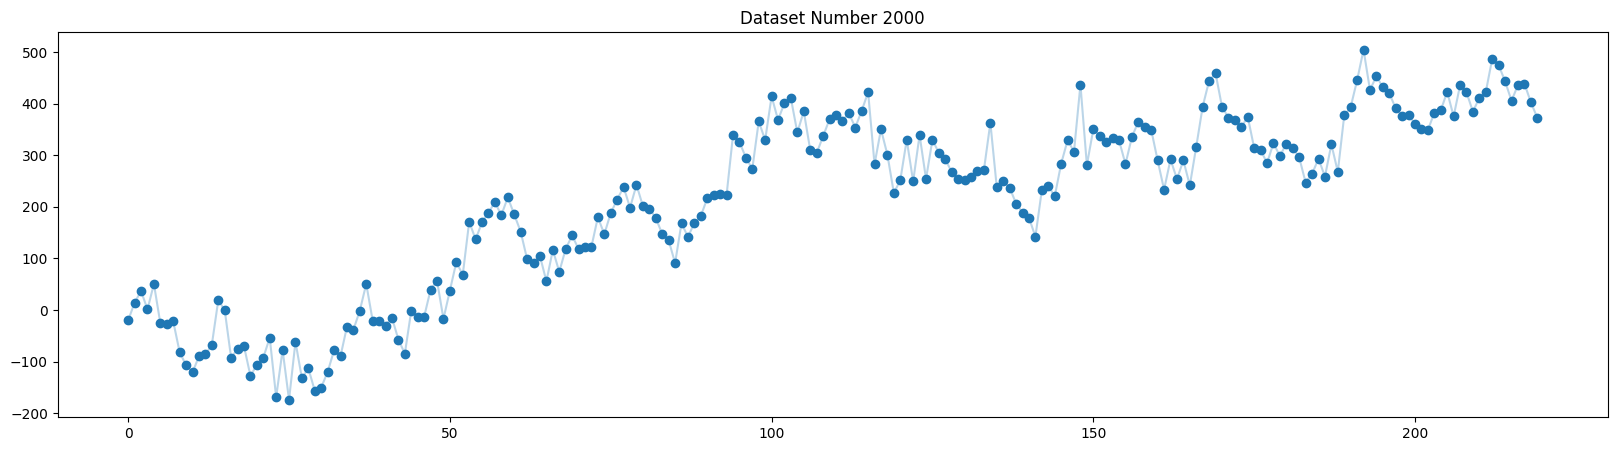

In [108]:
for i in [2,20,200,2000]:
    sts.plot_dataset(i)

ok, great, we've built some nice time series datasets. Now let's get to work predicting. For each time series in our training set we'll try to predict the last 20 values from the first 200 values, and then we'll see how our predictions look on the time series we keep in our test set. 



In [109]:
training_datasets = np.array(sts.datasets[0:15800])
test_datasets = np.array(sts.datasets[15800:])

In [125]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=200, output_size=20):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = 120
        self.core_size = 80
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            #nn.Linear(self.hidden_size, self.core_size),
            #nn.ReLU(),
            #nn.Linear(self.core_size, self.hidden_size),
            #nn.ReLU(),
            nn.Linear(self.hidden_size, self.output_size),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [126]:
nn_model = NeuralNetwork()

# Normalize the features
scaler_X = StandardScaler()
X = training_datasets[:, 0:200]
X_normalized = scaler_X.fit_transform(X)

# Normalize the targets
scaler_y = StandardScaler()
y = training_datasets[:, 200:220]
y_normalized = scaler_y.fit_transform(y)

# Convert to tensors
X_tensor = torch.tensor(X_normalized, dtype=torch.float32)
y_tensor = torch.tensor(y_normalized, dtype=torch.float32)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=20, shuffle=True)  # You can adjust the batch size


criterion = nn.MSELoss() 
optimizer = optim.SGD(nn_model.parameters(), lr=0.01)

num_epochs = 50
for epoch in range(num_epochs):
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        outputs = nn_model(batch_X)  # This should give the predicted values
        
        # Compute the loss
        loss = criterion(outputs, batch_y)  # Outputs and y should both be of shape [batch_size, 20]
        
        # Backward pass
        loss.backward()
        optimizer.step()  # Update weights
        
        # Print loss for monitoring
    print(f'Epoch [{epoch+1}/{num_epochs}], Last Loss: {loss.item():.4f}')

Epoch [1/50], Last Loss: 0.0424
Epoch [2/50], Last Loss: 0.0451
Epoch [3/50], Last Loss: 0.0363
Epoch [4/50], Last Loss: 0.0338
Epoch [5/50], Last Loss: 0.0391
Epoch [6/50], Last Loss: 0.0449
Epoch [7/50], Last Loss: 0.0416
Epoch [8/50], Last Loss: 0.0221
Epoch [9/50], Last Loss: 0.0364
Epoch [10/50], Last Loss: 0.0389
Epoch [11/50], Last Loss: 0.0297
Epoch [12/50], Last Loss: 0.0224
Epoch [13/50], Last Loss: 0.0266
Epoch [14/50], Last Loss: 0.0280
Epoch [15/50], Last Loss: 0.0274
Epoch [16/50], Last Loss: 0.0353
Epoch [17/50], Last Loss: 0.0454
Epoch [18/50], Last Loss: 0.0463
Epoch [19/50], Last Loss: 0.0229
Epoch [20/50], Last Loss: 0.0326
Epoch [21/50], Last Loss: 0.0279
Epoch [22/50], Last Loss: 0.0323
Epoch [23/50], Last Loss: 0.0342
Epoch [24/50], Last Loss: 0.0370
Epoch [25/50], Last Loss: 0.0432
Epoch [26/50], Last Loss: 0.0510
Epoch [27/50], Last Loss: 0.0263
Epoch [28/50], Last Loss: 0.0416
Epoch [29/50], Last Loss: 0.0319
Epoch [30/50], Last Loss: 0.0270
Epoch [31/50], Last

In [127]:
# let's see our performance
X_pred = test_datasets[:, 0:200]
X_pred_normalized = scaler_X.transform(X_pred)

X_pred_tensor = torch.tensor(X_pred_normalized, dtype=torch.float32)
y_pred = nn_model(X_pred_tensor)
y_pred_np = scaler_y.inverse_transform(y_pred.detach().numpy())
projections = np.append(test_datasets[:, 0:200], y_pred_np, axis=1)

In [128]:
def plot_projected_value(i, ds_real, ds_proj):
    plt.figure(figsize=(18,5))
    plt.plot(ds_real[i, :], label= 'real data')
    plt.plot(ds_proj[i,:], linestyle='--', label='proj data')
    plt.axvline(200-1, linestyle='--', color='green', label='present', alpha=0.4)
    plt.legend()

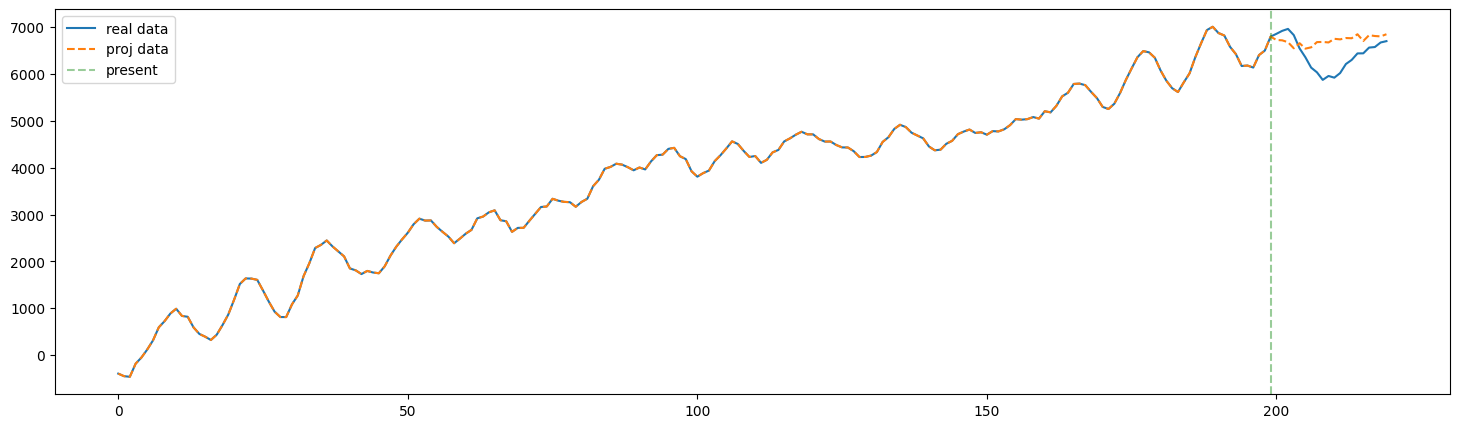

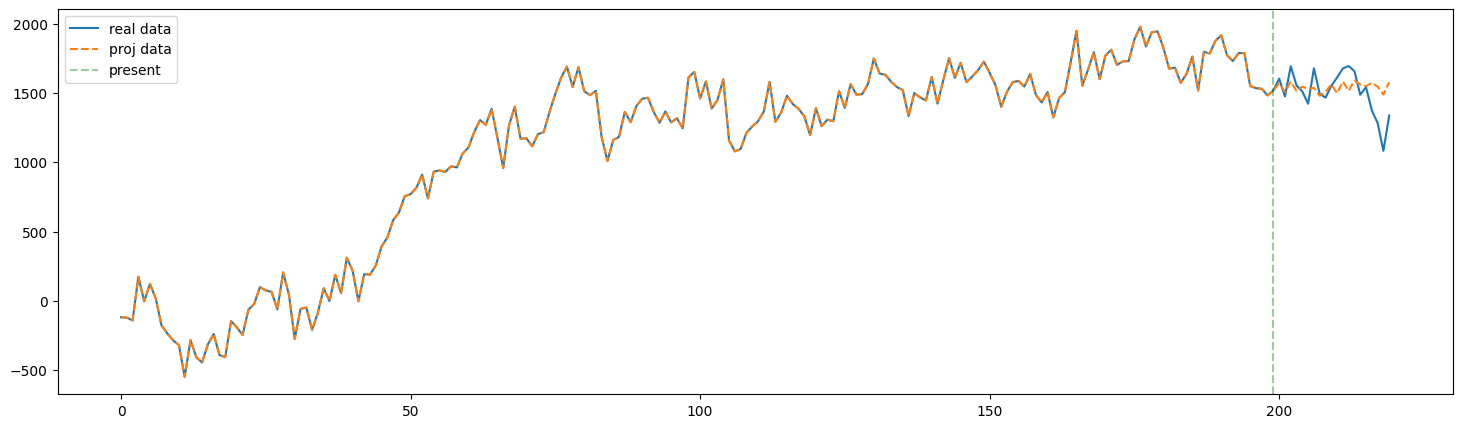

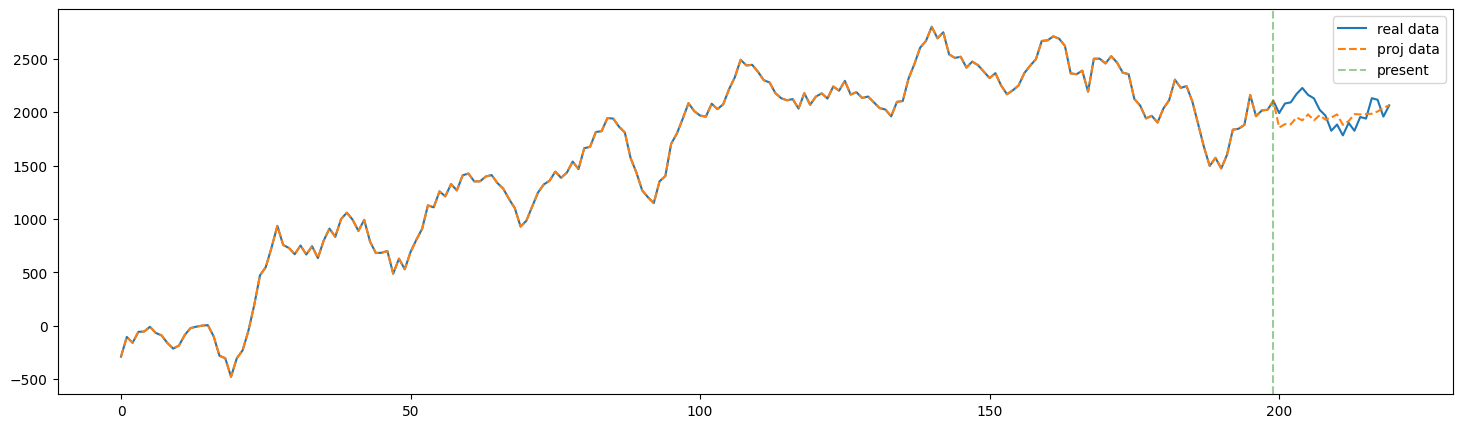

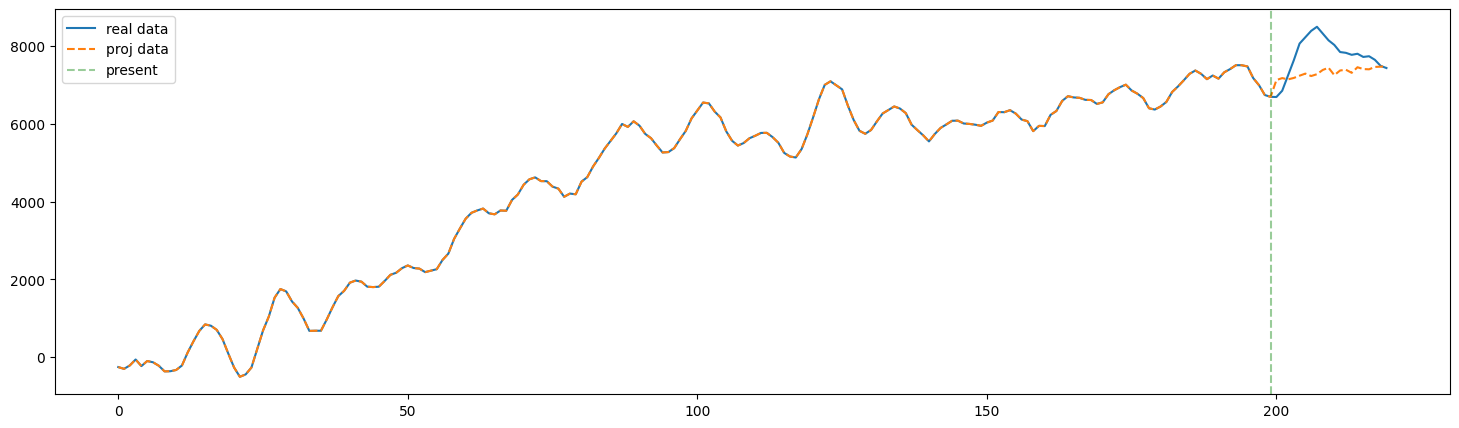

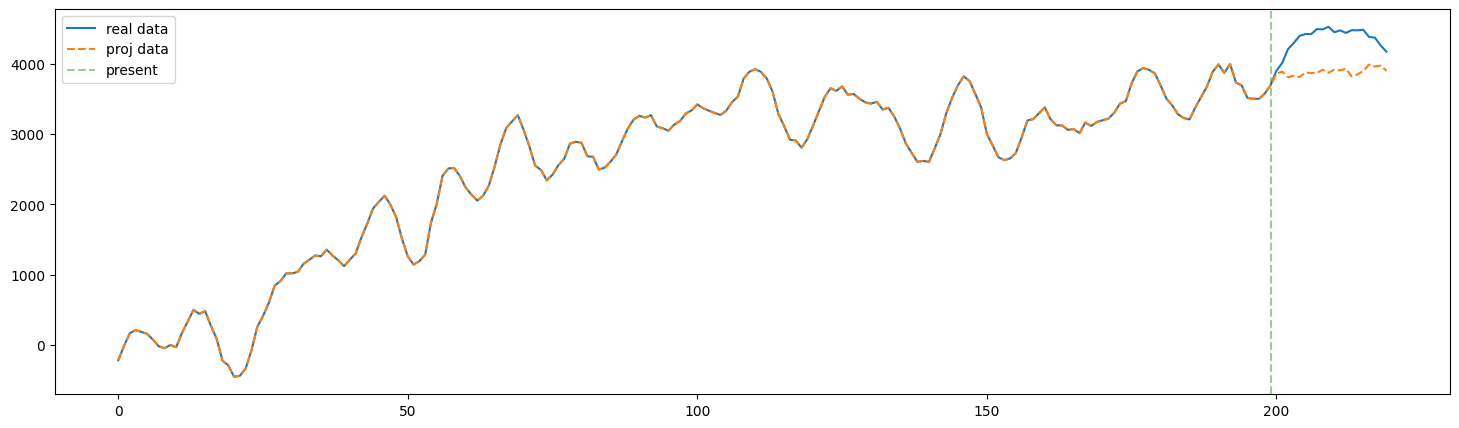

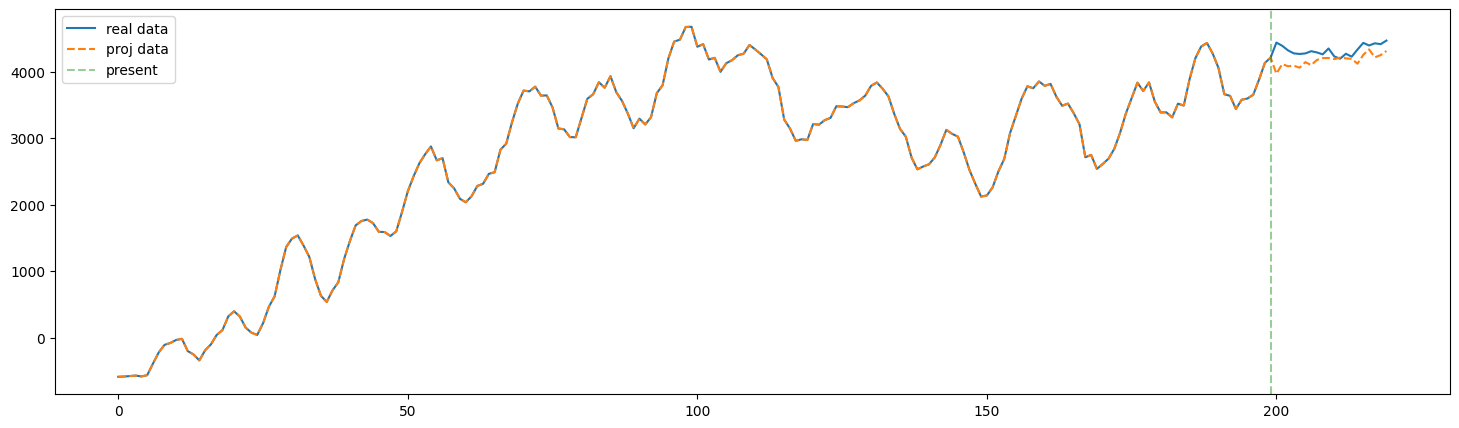

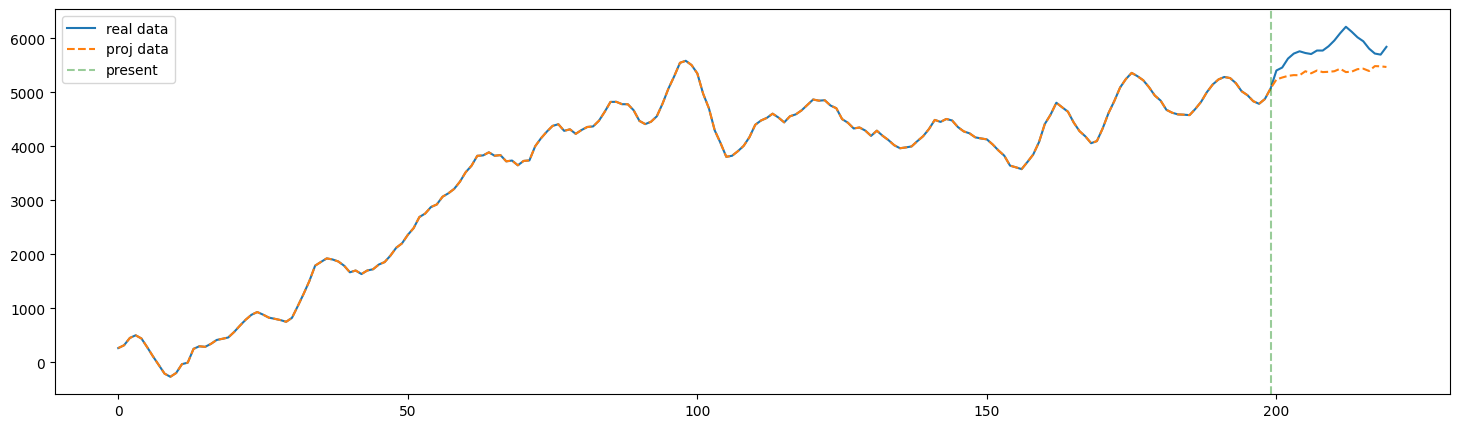

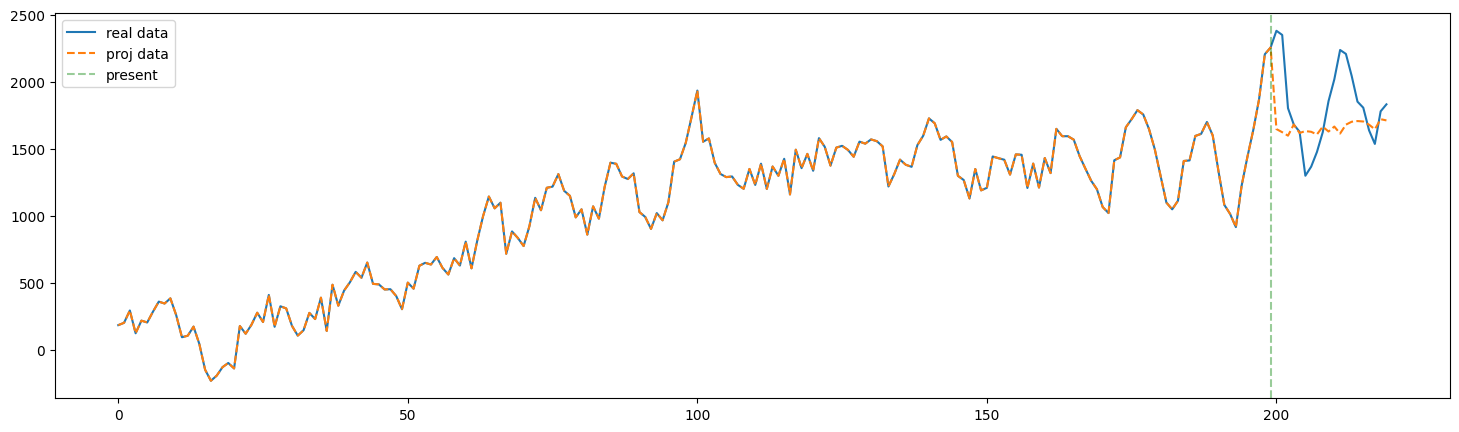

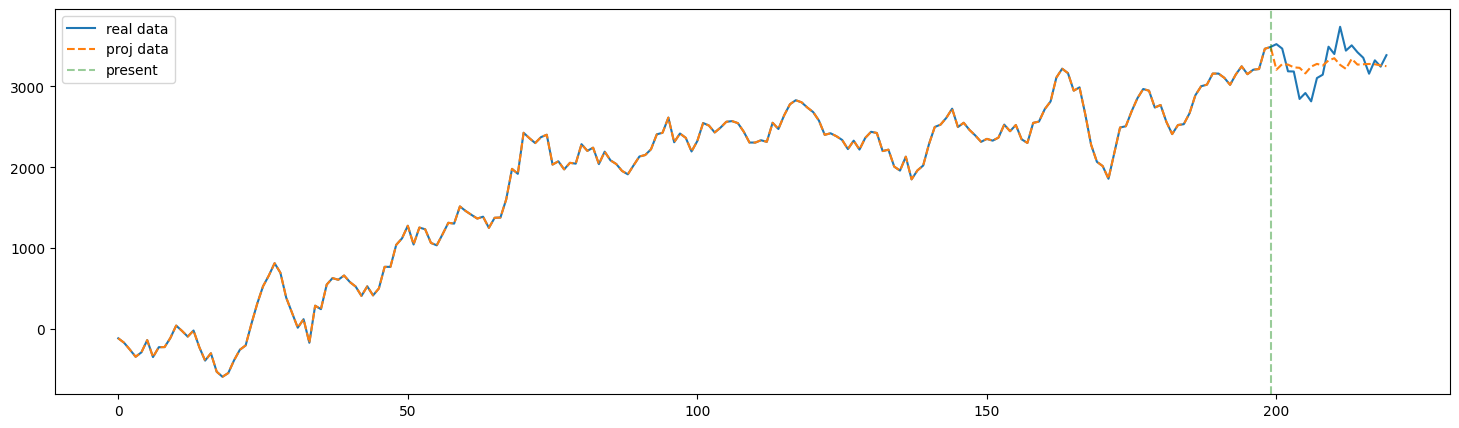

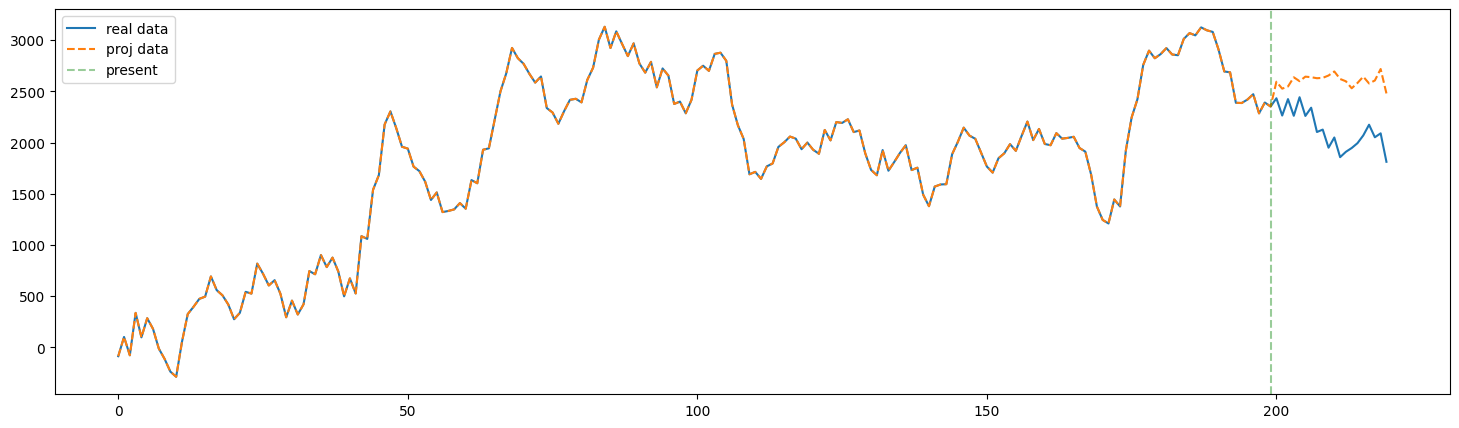

In [129]:
for i in range(0,100,10):
    plot_projected_value(i, test_datasets, projections)